In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler

In [ ]:
uploaded = files.upload()

Saving test.csv to test.csv


In [ ]:
df = pd.read_csv('test.csv')
labels = []
cell= []
xmax = list(df.xmax)
xmin = list(df.xmin)
ymax = list(df.ymax)
ymin = list(df.ymin)

df.head()
for index, row in df.iterrows():
  labels.append(row['filename'])
  cell.append(row['cell_type'])
 #

df

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,WBC,260,491,177,376
1,BloodImage_00000.jpg,RBC,78,184,336,435
2,BloodImage_00000.jpg,RBC,63,169,237,336
3,BloodImage_00000.jpg,RBC,214,320,362,461
4,BloodImage_00000.jpg,RBC,414,506,352,445
...,...,...,...,...,...,...
4883,BloodImage_00410.jpg,Platelets,239,291,275,321
4884,BloodImage_00410.jpg,Platelets,121,189,260,320
4885,BloodImage_00410.jpg,Platelets,57,104,119,167
4886,BloodImage_00410.jpg,Platelets,1,29,286,327


In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [ ]:
import glob
X_data = []
files = sorted(glob.glob('*.jpg'), key=numericalSort)
for myFile in files:
    image = plt.imread(myFile)
    X_data.append (image)


In [ ]:
imgnew=[]
yl=[]
images = pd.DataFrame([])
index = 0
label = labels[0]
uax = 0
counterRBC = 0
for data in labels[:4888]:   
    if data != label:
      label = data
      uax =uax +1

    image =  X_data[uax]
    imgnew = image[ymin[index]:ymax[index],xmin[index]:xmax[index]]
    
    if cell[index] =='RBC':
      counterRBC = counterRBC + 1
      if counterRBC < 350:
        im = Image.fromarray(imgnew)
        im.save('finalimages/'+ (str(index).zfill(5))+'.jpeg')
        yl.append(cell[index])
        
    else:    
      if imgnew.size > 0:
        im = Image.fromarray(imgnew)    
        im.save('finalimages/'+(str(index).zfill(5))+'.jpeg')
        yl.append(cell[index])
    
    index = index + 1

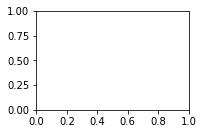

In [ ]:
from glob import iglob
from PIL import Image
import cv2
index = 0
faces = pd.DataFrame([])
filespath = sorted(iglob('finalimages/*.jpeg'))
plt.subplot(2, 2, 1) 

for path in filespath:

  imagefin=cv2.imread(path)
  stretch_near =  cv2.resize(imagefin, (35,35), interpolation = cv2.INTER_AREA)
  im = Image.fromarray(stretch_near)     
  im.save('resized35/'+str(index)+'.jpeg')
  face = pd.Series(stretch_near.flatten(),name=yl[index])
  index = index + 1
  faces = faces.append(face)


In [ ]:
faces = np.asanyarray(faces)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm, metrics

In [ ]:
y = []
for i in yl:
  if i == 'WBC':
    y.append(1)
  if i == 'RBC':
    y.append(2)
  if i == 'Platelets':
    y.append(3)
y = np.asanyarray(y)

y.size

1082

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(faces, y, test_size = 0.20)

In [ ]:
np.unique(ytrain)

NameError: ignored

In [ ]:
scaler = StandardScaler()
images_scaled = scaler.fit_transform(faces)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(images_scaled, y, test_size = 0.30)

In [ ]:
param_dict = {"pca__n_components":[2, 3, 4,5,6,7,10],
              "SVM__gamma":[0.0001,0.001,0.0002,0.00001,1]}
           

In [ ]:
pca = PCA()
pipe = Pipeline(steps=[('pca', PCA()),('SVM', svm.SVC())])

search_obj = RandomizedSearchCV(pipe, param_dict, 
                                scoring='f1_macro', n_iter=15)

In [ ]:
search_obj.fit(xtrain, ytrain)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('SVM',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
     

In [ ]:
print("The best parameters: {0}".format(search_obj.best_params_))
best_model = search_obj.best_estimator_

The best parameters: {'pca__n_components': 7, 'SVM__gamma': 0.0002}


In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

train_scores = []
dev_scores = []
scores = cross_val_score(best_model3, xtrain, ytrain, cv=30, scoring='f1_macro')
print(scores)

for train_index, test_index in kf.split(xtrain):
  train, dev = xtrain[train_index], xtrain[test_index]
  y_train, y_dev = ytrain[train_index], ytrain[test_index]
  best_model3.fit(train, y_train)
  train_scores.append(best_model3.score(train,y_train))
  dev_scores.append(best_model3.score(dev, y_dev))

print('Average: ',scores.mean(), scores.std())

[0.9628483  0.9628483  0.9628483  1.         0.96023392 0.92118163
 0.9628483  1.         0.91522925 1.         1.         0.96023392
 0.96078431 0.96023392 1.         0.96023392 0.9212963  1.
 0.96023392 1.         0.96023392 0.96023392 1.         1.
 1.         1.         1.         0.9628483  1.         0.96023392]
Average:  0.9738201440420222 0.025897868646929


In [ ]:
print('Train scores:',train_scores)
print('Train score avarage: ',np.mean(train_scores))
print('Test score: ',dev_scores)
print('Test score avarage: ',np.mean(dev_scores))

Train scores: [1.0, 1.0, 1.0, 1.0, 1.0]
Train score avarage:  1.0
Test score:  [0.9653179190751445, 0.9479768786127167, 0.9826589595375722, 0.9595375722543352, 0.930635838150289]
Test score avarage:  0.9572254335260115


In [ ]:
best_model3.fit(xtest, ytest)
test_scores = best_model3.score(xtest, ytest)
print('Test score: ',test_scores)

Test score:  1.0


In [ ]:
search_obj = RandomizedSearchCV(pipe, param_dict, 
                                scoring='f1_macro', n_iter=15)
fit_obj = search_obj.fit(xtrain, ytrain)
print(fit_obj.cv_results_['mean_test_score'])
best_model2 = fit_obj.best_estimator_

NameError: ignored

In [ ]:
from sklearn import metrics, preprocessing, tree
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer, roc_auc_score


In [ ]:
tsne = TSNE(n_components=2, n_iter=2000, n_jobs=-1)
x_2d = tsne.fit_transform(faces)
x_2d.shape

(1082, 2)

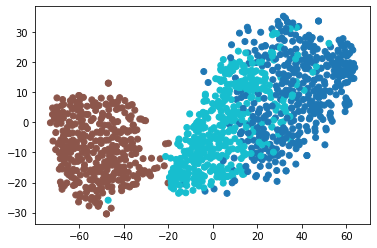

In [ ]:
plt.scatter(x_2d[:,0],x_2d[:,1], c=y, cmap=plt.cm.tab10)

In [ ]:
faces.shape

(1082, 3675)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
modelKN = Pipeline(steps=[('pca', PCA()),('KNN', KNeighborsClassifier())])

In [ ]:
param_dict3 = {"pca__n_components":[2, 3, 4,5],
              "KNN__n_neighbors":[3,4,5,6,7]}
search_obj = RandomizedSearchCV(modelKN, param_dict3, 
                                scoring='f1_macro', n_iter=20)
fit_obj = search_obj.fit(xtrain, ytrain)
print(fit_obj.cv_results_['mean_test_score'])
best_model4 = fit_obj.best_estimator_    

[0.87408648 0.88963815 0.89194211 0.89059499 0.87462752 0.88378257
 0.8993411  0.89931366 0.88157563 0.88927305 0.89297849 0.90208758
 0.88920622 0.8917577  0.90739293 0.90592583 0.89214661 0.89967803
 0.89439156 0.9034283 ]


In [ ]:
print("The best parameters: {0}".format(fit_obj.best_params_))

The best parameters: {'pca__n_components': 4, 'KNN__n_neighbors': 6}


In [ ]:

pipe2 = Pipeline(steps=[('pca', PCA()),('Random', RandomForestClassifier())])
param_dict2 = {"pca__n_components":[4,5,6],
              "Random__n_estimators":[50,100,120,200]}

search_obj = RandomizedSearchCV(pipe2, param_dict2, 
                                scoring='f1_macro', n_iter=5)
fit_obj = search_obj.fit(xtrain, ytrain)
print(fit_obj.cv_results_['mean_test_score'])
best_model3 = fit_obj.best_estimator_
    

[0.9104031  0.96421705 0.9653415  0.9607396  0.90208786]


In [ ]:
print("The best parameters: {0}".format(fit_obj.best_params_))

The best parameters: {'pca__n_components': 6, 'Random__n_estimators': 120}


In [ ]:

pipe2.fit(train,y_train)

print('Train: ', pipe2.score(xtrain,ytrain))
print('Test: ', pipe2.score(xtest,ytest))

Train:  0.8784676354029062
Test:  0.3292307692307692


In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
modelMLP = Pipeline(steps=[('pca', PCA()),('MLP', MLPClassifier())])

In [ ]:
modelMLP.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pca', 'MLP', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'MLP__activation', 'MLP__alpha', 'MLP__batch_size', 'MLP__beta_1', 'MLP__beta_2', 'MLP__early_stopping', 'MLP__epsilon', 'MLP__hidden_layer_sizes', 'MLP__learning_rate', 'MLP__learning_rate_init', 'MLP__max_fun', 'MLP__max_iter', 'MLP__momentum', 'MLP__n_iter_no_change', 'MLP__nesterovs_momentum', 'MLP__power_t', 'MLP__random_state', 'MLP__shuffle', 'MLP__solver', 'MLP__tol', 'MLP__validation_fraction', 'MLP__verbose', 'MLP__warm_start'])

In [ ]:
param_dict4 = {"pca__n_components":[2, 3, 4],
              "MLP__hidden_layer_sizes":[(100,50,30),(100,30,30)]}
search_obj = RandomizedSearchCV(modelMLP, param_dict4, 
                                scoring='f1_macro', n_iter=5)
fit_obj = search_obj.fit(xtrain, ytrain)
print(fit_obj.cv_results_['mean_test_score'])
best_model5 = fit_obj.best_estimator_  

[0.8608132  0.88104138 0.88150749 0.86230458 0.87676735]


In [ ]:
print("The best parameters: {0}".format(fit_obj.best_params_))

The best parameters: {'pca__n_components': 2, 'MLP__hidden_layer_sizes': (100, 30, 30)}


In [ ]:
adb = AdaBoostClassifier(n_estimators = 100)
adb.fit(xtrain,ytrain)

print('Train: ', adb.score(xtrain,ytrain))
print('Test: ', adb.score(xtest,ytest))

Train:  0.9564068692206077
Test:  0.916923076923077


In [ ]:
ypred = best_model4.predict(xtest)


In [ ]:
print('Classification report: \n', metrics.classification_report(ytest, ypred))

Classification report: 
               precision    recall  f1-score   support

           1       0.87      0.94      0.90       115
           2       1.00      1.00      1.00       112
           3       0.92      0.84      0.88        98

    accuracy                           0.93       325
   macro avg       0.93      0.93      0.93       325
weighted avg       0.93      0.93      0.93       325



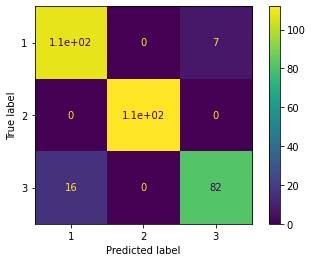

In [ ]:
metrics.plot_confusion_matrix(best_model4, xtest, ytest)

In [ ]:
from PIL import Image
